## Thompson Sampling

At each step the learner has to select which arm to pull among the possible arms. To do so, the learner has to estimate the IPO function of each arm by interacting with the environment. The environment is defined by a number of arms and a probability distribution for each arm reward function. It interacts with the learner by returning a stochastic reward depending on the pulled arm.

In [1]:
import numpy as np

In [2]:
class Environment():

  def __init__(self,n_arms,probabilities):
    self.n_arms = n_arms
    self.probabilities = probabilities  # we will use bernoullian distributions (represented by one value of each arm)

  # function to model the interaction with the learner
  def round_(self, pulled_arm):
    reward = np.random.binomial(1,self.probabilities[pulled_arm])
    return reward

A learner object is defined by the number of arms that he can pull, the current round and the list of collected rewards related to the arms. The learner interacts with the environment by selecting the arm to pull at each round and observing the stochastic reward given by the environment.

In [3]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

We extend the class learner to implement the Thompson class learner

In [4]:
class TS_Learner(Learner):
  def __init__(self,n_arms):
    super().__init__(n_arms)
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions

  def pull_arm(self):
    idx = np.argmax(np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1]))
    return idx

  # update parameters each time a reward is observed
  def update(self,pulled_arm,reward):
    self.t += 1
    self.update_observations(pulled_arm,reward)
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1.0 - reward

We can implement a Greedy Learner to compare with the Thompson Learner

In [ ]:
class Greedy_Learner(Learner):
  def __init__(self,n_arms):
    super().__init__(n_arms)
    self.expected_rewards = np.zeros(n_arms)   # at each round it computes the estimation of expected reward for each arm

  # function that selects which arm to pull at each round t (by maximizing the expected rewards array)
  def pull_arm(self):
    # we want to ensure that each arms is pulled at least once
    if(self.t < self.n_arms):
      return self.t
    idxs = np.argwhere(self.expected_rewards == self.expected_rewards.max()).reshape(-1)
    # to return a single value, slected at random among the maximum ones
    pulled_arm = np.random.choice(idxs)
    return pulled_arm

  # function update
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    # recursive update of the average by using the new reward value
    self.expected_rewards[pulled_arm] = ( self.expected_rewards[pulled_arm]*(self.t - 1) + reward ) / self.t

In [ ]:
class UCB1(Learner):
  def __init__(self,n_arms):
    super().__init__(n_arms)
    self.empirical_means = np.zeros(n_arms)
    self.confidence = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max()))
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.collected_rewards = np.append(self.collected_rewards, reward)
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(self.t - 1) + reward ) / self.t
    self.confidence[pulled_arm] = np.sqrt(2*np.log(self.t)/(self.rewards_per_arm[pulled_arm].len() + 1))
    self.update_observations(pulled_arm, reward)

We create an example in which we compare the performance of the Thompson Learner and the Greedy Learner.

In [ ]:
import matplotlib.pyplot as plt

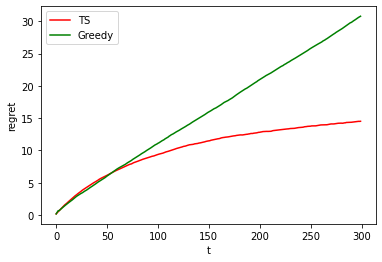

In [ ]:
n_arms = 4
p = np.array([0.15,0.1,0.1,0.35])     # bernoulli distributions for the reward functions
opt = p[3]                            # last arm is the optimal one
T = 300                               # horizon of experiment
n_experiment = 1000                   # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments
# to store results
ts_rewards_per_experiment = []
gr_rewards_per_experiment = []


for e in range(0,n_experiment):       # for each experiment we simulate the environment-learner interaction
  env = Environment(n_arms = n_arms, probabilities = p)
  ts_learner = TS_Learner(n_arms = n_arms)
  gr_learner = Greedy_Learner(n_arms = n_arms)
  for t in range(0,T):                # iterate on the number of rounds/horizon and for each iteration simulate the interaction

    # Thompson Sampling Learner
    pulled_arm_ts = ts_learner.pull_arm()
    reward_ts = env.round_(pulled_arm_ts)
    ts_learner.update(pulled_arm_ts,reward_ts)

    # Greedy Learner
    pulled_arm_gl = gr_learner.pull_arm()
    reward_gl = env.round_(pulled_arm_gl)
    gr_learner.update(pulled_arm_gl,reward_gl)

  # store values
  ts_rewards_per_experiment.append(ts_learner.collected_rewards)
  gr_rewards_per_experiment.append(gr_learner.collected_rewards)

# plot results
plt.figure(0)
plt.xlabel('t')
plt.ylabel('regret')
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - gr_rewards_per_experiment, axis = 0)), 'g')
plt.legend(['TS', 'Greedy'])
plt.show()




In [ ]:
ts_learner.beta_parameters

array([[  3.,  18.],
       [  1.,  11.],
       [  1.,  11.],
       [ 94., 169.]])

The regret of the greedy algorithm increases linearly, while the instantaneous regret of the TS decreases as the number of rounds increases.

NB: it is not always true that the reward is in {0,1}. If it is not, it is  good practice to normalize the reward to {0,1} (or convert the reward in some way in {0,1}, often done in TS), do the computations as usual and then scale everything back.